# Exercise: Transfer learning using MobileNetV3

In the field of machine learning, transfer learning is a powerful technique that leverages pre-trained models and applies them to new tasks. This approach allows us to save time and computational resources by reusing the knowledge gained from training on large datasets.

In this exercise we use MobileNetV3, a convolutional neural network architecture for mobile devices, to train a classifier for the Fashion-MNIST dataset using the PyTorch framework.

Fashion-MNIST is a drop-in replacement for MNIST (images of size 28x28 with 10 classes) but instead of hand-written digits it contains tiny images of clothes!

## Steps

1. Load the Fashion-MNIST dataset using the torchvision package.
2. Define a PyTorch model using the MobileNetV3 architecture.
3. Train the model on the Fashion-MNIST dataset.
4. Evaluate the model on the test set.

## Step 1: Load the Fashion-MNIST dataset

The torchvision package provides access to popular datasets, model architectures, and image transformations for computer vision.


In [1]:
# Load the Fashion-MNIST dataset

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms


def load_data(batch_size, data_dir="data"):
    """Load the Fashion-MNIST dataset."""

    # Define transforms to normalize the data
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )

    # Download and load the training data
    trainset = datasets.FashionMNIST(
        data_dir, download=True, train=True, transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True
    )

    # Download and load the test data
    testset = datasets.FashionMNIST(
        data_dir, download=True, train=False, transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True
    )

    return trainloader, testloader


trainloader, testloader = load_data(64)

100%|██████████| 26421880/26421880 [00:01<00:00, 16560634.36it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 263310.45it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4427984.44it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13770584.82it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Sometimes it's useful to create functions that will help us work with the labels when they're a little more complicated than the handwritten digits 0-9. Let's create those now.

In [2]:
# Define some helper functions to helps with the labels
def get_class_names():
    """Return the list of classes in the Fashion-MNIST dataset."""
    return [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]


def get_class_name(class_index):
    """Return the class name for the given index."""
    return get_class_names()[class_index]


def get_class_index(class_name):
    """Return the class index for the given name."""
    return get_class_names().index(class_name)


for class_index in range(10):
    print(f"class_index={class_index}, class_name={get_class_name(class_index)}")

class_index=0, class_name=T-shirt/top
class_index=1, class_name=Trouser
class_index=2, class_name=Pullover
class_index=3, class_name=Dress
class_index=4, class_name=Coat
class_index=5, class_name=Sandal
class_index=6, class_name=Shirt
class_index=7, class_name=Sneaker
class_index=8, class_name=Bag
class_index=9, class_name=Ankle boot


It's always good to inspect your data before you use it to train a model just to know everything is fine. You know what they say: garbage in, garbage out.

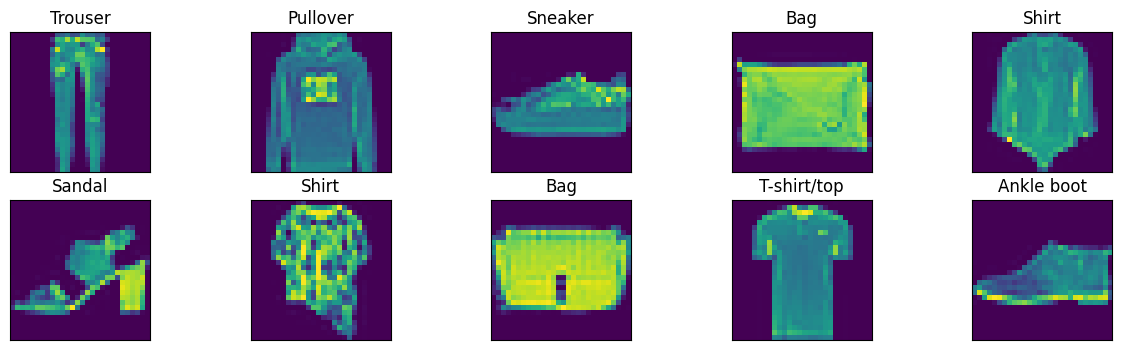

In [3]:
# Show 10 images from the training set with their labels

import matplotlib.pyplot as plt
import numpy as np


# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert from tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose dimensions


images, labels = next(iter(trainloader))  # get the first batch

# show images with labels
fig = plt.figure(figsize=(15, 4))
plot_size = 10

for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(get_class_name(int(labels[idx])))

## Step 2. Define a PyTorch model using the MobileNetV3 architecture.

The `torchvision.models.mobilenet_v3_large` class provides access to pre-trained MobileNetV3 model. We can use the model and replace the final layer with a fully-connected layer with 10 outputs since we have 10 classes. We can then freeze the weights of the convolutional layers and train only the new fully-connected layer.

Let's start with inspecting the original MobileNetV3 (small version) first:

In [4]:
# Load a pre-trained MobileNetV3 and inspect its structure
import torchvision.models as models

mobilenet_v3_model = models.mobilenet_v3_large(pretrained=True)
print(mobilenet_v3_model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /home/student/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 133MB/s] 


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

Take note of the `classifier` section of the model.

```
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=1024, bias=True)
    (1): Hardswish()
    (2): Dropout(p=0.2, inplace=True)
    (3): Linear(in_features=1024, out_features=1000, bias=True)
  )
```

There are 1000 output features, but our dataset does not have that many. See if you can complete the next cell so that it has the right number of output nodes.

In [9]:
# Replace <MASK> to complete this code cell

import torch.nn.functional as F
import torchvision.models as models
from torch import nn


# Define a model class that extends the nn.Module class
class MobileNetV3(nn.Module):
    def __init__(self):
        super(MobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 (Small) architecture
        self.model = models.mobilenet_v3_small(pretrained=True)
        
        # Replace the last fully-connected layer with a new one of the right size
        self.model.classifier[3] = nn.Linear(in_features=1024, out_features=10)

        # Freeze all the weights of the network except for the last fully-connected layer
        self.freeze()

    def forward(self, x):
        # Convert 1x28x28 input tensor to 3x28x28 tensor, to convert it to a color image
        x = x.repeat(1, 3, 1, 1)

        # Resize the input to 224x224, since MobileNetV3 (Small) expects images of that size
        if x.shape[2:] != (224, 224):
            x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)

        # Forward pass
        return self.model(x)

    def freeze(self):
        # Freeze all the weights of the network except for the last fully-connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the final layer
        for param in self.model.classifier[3].parameters():
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all the weights of the network
        for param in self.model.parameters():
            param.requires_grad = True


# Create an instance of the MobileNetV3 model
model = MobileNetV3()
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/student/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 33.6MB/s]


MobileNetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

## Step 3. Train the model on the MNIST dataset

We can train the model using the standard PyTorch training loop. For the loss function, we'll use CrossEntropyLoss. We also use the Adam optimizer with a learning rate of 0.002. We train the model for 1 epoch so we can see how the model performs after just one pass of the training data.

In [10]:
# Replace <MASK> to complete this code cell

import torch
import torch.nn as nn

# Define the loss function and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

Now let's choose our device automatically (CPU, GPU, or MPS) and write our training loop!

The MPS backend is for M1/M2/etc Macs.

If you are having any errors running the code locally, you should try to use the `cpu` mode manually, i.e. `device = torch.device("cpu")`

In [11]:
# Set the device as GPU, MPS, or CPU according to availability
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [12]:
# Replace <MASK> to complete this code cell

# Create a PyTorch training loop

model = model.to(device)  # Move the model weights to the device

epochs = 1
for epoch in range(epochs):
    for batch_num, (images, labels) in enumerate(trainloader):
        # Move tensors to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss and perform backprop
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Update the weights
        optimizer.step()

        # Print the loss for every 100th iteration
        if (batch_num) % 100 == 0:
            print(
                "Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}".format(
                    epoch + 1, epochs, batch_num + 1, len(trainloader), loss.item()
                )
            )

Epoch [1/1], Batch [1/938], Loss: 2.2913
Epoch [1/1], Batch [101/938], Loss: 0.2956
Epoch [1/1], Batch [201/938], Loss: 0.5222
Epoch [1/1], Batch [301/938], Loss: 0.4007
Epoch [1/1], Batch [401/938], Loss: 0.5041
Epoch [1/1], Batch [501/938], Loss: 0.4556
Epoch [1/1], Batch [601/938], Loss: 0.5409
Epoch [1/1], Batch [701/938], Loss: 0.4690
Epoch [1/1], Batch [801/938], Loss: 0.3086
Epoch [1/1], Batch [901/938], Loss: 0.6577


## Step 4. Evaluate the model on the test set

We evaluate the model on the test set by:
* printing the accuracy
* plotting a few examples of correct and incorrect predictions.


In [13]:
# Replace <MASK> to complete this code cell

# Print the loss and accuracy on the test set
correct = 0
total = 0
loss = 0

for images, labels in testloader:
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss += loss_fn(outputs, labels)

    # torch.max return both max and argmax. We get the argmax here.
    _, predicted = torch.max(outputs.data, 1)

    # Compute the accuracy
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
    "Test Accuracy of the model on the test images: {} %".format(100 * correct / total)
)
print("Test Loss of the model on the test images: {}".format(loss))

Test Accuracy of the model on the test images: 85.16 %
Test Loss of the model on the test images: 64.87602233886719


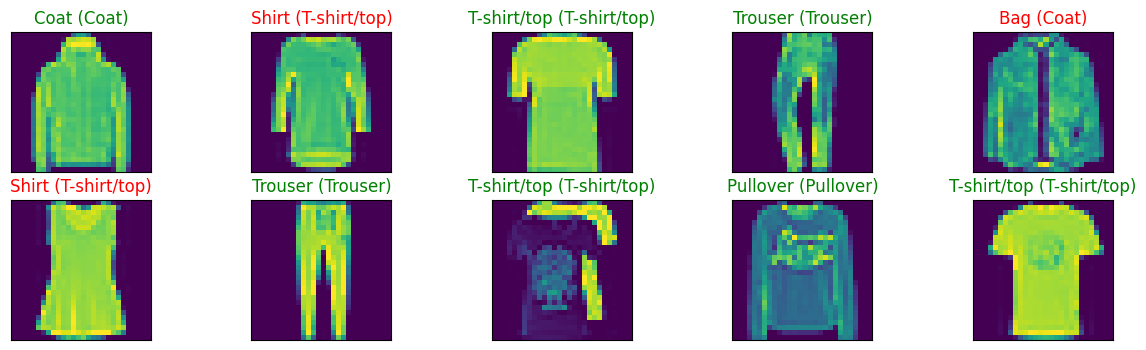

In [14]:
# Plotting a few examples of correct and incorrect predictions

import matplotlib.pyplot as plt
import numpy as np

# Get the first batch of images and labels
images, labels = next(iter(testloader))

# Move tensors to the configured device
images = images.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(images)
_, predicted = torch.max(outputs.data, 1)

# Plot the images with labels, at most 10
fig = plt.figure(figsize=(15, 4))

for idx in np.arange(min(10, len(images))):
    ax = fig.add_subplot(2, 10 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images.cpu()[idx]))
    ax.set_title(
        "{} ({})".format(get_class_name(predicted[idx]), get_class_name(labels[idx])),
        color=("green" if predicted[idx] == labels[idx] else "red"),
    )